# 단어 Level 번역기 만들기
데이터는 상위 33,000개의 샘플만 사용  
  
  
### 데이터 불러오기 및 전처리

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import os

In [2]:
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
# lines.sample(5) #샘플 5개 출력
lines.head(5)

전체 샘플의 수 : 197463


,eng,fra,cc
0,Go.,Va !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,Marche.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,En route !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Go.,Bouge !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
4,Hi.,Salut !,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


In [3]:
# 3만 3천개의 데이터만 사용한다.(train 30000, test 3000)
lines = lines[['eng', 'fra']][:33000]
lines.head()

,eng,fra
0,Go.,Va !
1,Go.,Marche.
2,Go.,En route !
3,Go.,Bouge !
4,Hi.,Salut !


In [4]:
# 시작 토큰과 종료 토큰 추가
sos_token = '<sos>'
eos_token = '<eos>'
# sos_token과 eos_token사이에 ' '를 추가하여야 토그나이저에서 문제를 일으키지 않는다.
lines.fra = lines.fra.apply(lambda x : sos_token + ' ' + x + ' '+ eos_token)
print('전체 샘플의 수 :',len(lines))
lines.head(10)

전체 샘플의 수 : 33000


,eng,fra
0,Go.,<sos> Va ! <eos>
1,Go.,<sos> Marche. <eos>
2,Go.,<sos> En route ! <eos>
3,Go.,<sos> Bouge ! <eos>
4,Hi.,<sos> Salut ! <eos>
5,Hi.,<sos> Salut. <eos>
6,Run!,<sos> Cours ! <eos>
7,Run!,<sos> Courez ! <eos>
8,Run!,<sos> Prenez vos jambes à vos cous ! <eos>
9,Run!,<sos> File ! <eos>


In [5]:
# 모든 대문자 소문자 변환
lines['eng']=lines['eng'].str.lower()
lines['fra']=lines['fra'].str.lower()
lines.head(10)

,eng,fra
0,go.,<sos> va ! <eos>
1,go.,<sos> marche. <eos>
2,go.,<sos> en route ! <eos>
3,go.,<sos> bouge ! <eos>
4,hi.,<sos> salut ! <eos>
5,hi.,<sos> salut. <eos>
6,run!,<sos> cours ! <eos>
7,run!,<sos> courez ! <eos>
8,run!,<sos> prenez vos jambes à vos cous ! <eos>
9,run!,<sos> file ! <eos>


In [6]:
# 영어 토큰화
eng_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')   # 문자 단위로 Tokenizer를 생성합니다. 
eng_tokenizer.fit_on_texts(lines.eng)               # eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(lines.eng)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:3] # 0,1,2모두 go 기 때문에 같을 수 밖에 없으니 당황하지 말 것

[[22], [22], [22]]

In [7]:
# 프랑스어 토큰화
fra_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')   # 문자 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(lines.fra)                 # fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(lines.fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

[[1, 59, 2], [1, 351, 2], [1, 22, 499, 2]]

In [8]:
# 디코더 토큰 중 디코더 입력 데이터에 종료 토큰과 디코더 target 데이터에 시작 토큰 제거
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [9]:
# 패딩 길이 확인을 위해 영어와 프랑스어 시퀸스의 최대 길이를 구한다.(단어 단위)
max_eng_seq_len=max([len(k_len) for k_len in input_text])
max_fra_seq_len=max([len(f_len) for f_len in target_text])
print("영어 최대 길이:", max_eng_seq_len)
print("프랑스어 최대 길이:", max_fra_seq_len)

영어 최대 길이: 6
프랑스어 최대 길이: 14


In [10]:
encoder_input= pad_sequences(encoder_input, maxlen=max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 6)
프랑스어 입력데이터의 크기(shape) : (33000, 14)
프랑스어 출력데이터의 크기(shape) : (33000, 14)


In [11]:
print(encoder_input[0])

[22  0  0  0  0  0]


In [12]:
# 각 단어장 크기 확인
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4799
프랑스어 단어장의 크기 : 10009


In [13]:
# encoder_input = to_categorical(encoder_input)
# decoder_input = to_categorical(decoder_input)
# decoder_target = to_categorical(decoder_target)
# print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
# print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
# print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

In [14]:
# 노드와 마찬가지로 3000건만 검증데이터로 준다.
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

np.shape(encoder_input_train)

영어 학습데이터의 크기(shape) : (33000, 6)
프랑스어 학습 입력데이터의 크기(shape) : (33000, 14)
프랑스어 학습 출력데이터의 크기(shape) : (33000, 14)


(30000, 6)

In [15]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

### 모델 형성 및 훈련

In [16]:
encoder_inputs = Input(shape=(None,))
# 단어장의 크기 및 임베딩 벡터 차원입력
enc_emb =  Embedding(4799, 8)(encoder_inputs)
encoder_lstm = LSTM(units=256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

In [17]:
# 디코더 입력 텐서 생성.(교사 강요)
decoder_inputs = Input(shape=(None,))
# 단어장의 크기 및 임베딩 벡터 차원입력
fra_emb= Embedding(10009, 8)(decoder_inputs)
decoder_lstm = LSTM(units=256, return_sequences = True, return_state=True)
decoder_outputs, _, _= decoder_lstm(fra_emb)

In [18]:
# 결과 중 가장 확률이 높은 하나의 단어만 선택
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [19]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [20]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 8)      80072       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  271360      embedding_1[0][0]                
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [21]:
hist=model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)

Epoch 1/50
235/235 [==============================] - 7s 18ms/step - loss: 2.5279 - val_loss: 2.2142
Epoch 2/50
235/235 [==============================] - 4s 16ms/step - loss: 1.7265 - val_loss: 2.0001
Epoch 3/50
235/235 [==============================] - 4s 16ms/step - loss: 1.6105 - val_loss: 1.9228
Epoch 4/50
235/235 [==============================] - 4s 16ms/step - loss: 1.5593 - val_loss: 1.8856
Epoch 5/50
235/235 [==============================] - 4s 16ms/step - loss: 1.5188 - val_loss: 1.8643
Epoch 6/50
235/235 [==============================] - 4s 16ms/step - loss: 1.4843 - val_loss: 1.8283
Epoch 7/50
235/235 [==============================] - 4s 16ms/step - loss: 1.4545 - val_loss: 1.8078
Epoch 8/50
235/235 [==============================] - 4s 16ms/step - loss: 1.4290 - val_loss: 1.7949
Epoch 9/50
235/235 [==============================] - 4s 17ms/step - loss: 1.4066 - val_loss: 1.7867
Epoch 10/50
235/235 [==============================] - 4s 17ms/step - loss: 1.3869 - val_lo

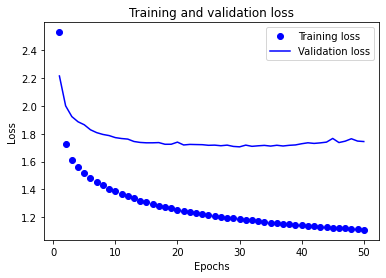

In [22]:
# 시각화
import matplotlib.pyplot as plt

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss') # bo는 파란색 점
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 파란색 실선
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 모델 테스트하기

In [23]:
encoder_model = Model(inputs = encoder_inputs, outputs = [state_h, state_c])
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 8)           38392     
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 271360    
Total params: 309,752
Trainable params: 309,752
Non-trainable params: 0
_________________________________________________________________


In [24]:
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(None,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(None,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# decoder_lstm에 fra_emb 적용.
decoder_outputs, state_h, state_c = decoder_lstm(fra_emb, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states = [state_h, state_c]

In [25]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 8)      80072       input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [26]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [27]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = fra2idx['<sos>']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '<eos>' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [28]:
import numpy as np
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][5:len(lines.fra[seq_index])-5])
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1])

-----------------------------------
입력 문장: go.
정답 문장:  bouge ! 
번역기가 번역한 문장:  je suis un homm
-----------------------------------
입력 문장: hello!
정답 문장:  bonjour ! 
번역기가 번역한 문장:  je suis un homm
-----------------------------------
입력 문장: got it?
정답 문장:  t'as capté ? 
번역기가 번역한 문장:  je suis un homm
-----------------------------------
입력 문장: hang on.
정답 문장:  tiens bon ! 
번역기가 번역한 문장:  je suis un homm
-----------------------------------
입력 문장: here's $5.
정답 문장:  voilà cinq dollars. 
번역기가 번역한 문장:  je suis un homm


회고

정말 NLP를 할 때마다 샐프 믹서기가 되는 느낌이다. 생명을 갈아 연명하는 삶이 이런 느낌일까? 늘 NLP는 어렵다. ML관련하여 가지고 있던 고질적인 문제를 다시 한번 맞이한 것 같다.  
  
가장 처음으로 마주한 어려움은 문자에서 단어로 바꿔어 토큰화를 시키는 것이었다. 토크나이저에 자동 필터가 달려있는데 이를 인지하지 못해서 '<sos>'와 '<eos>'가 제대로 나오지 않았고, 띄어쓰기를 하지 않아 토큰화도 이상하게 되었던 것을 데이터를 일일이 확인해가며 고칠 수 있었다.    
    
두번째 난관은 커널이 계속 죽는 것이었다. 모델을 만들고 .fit()으로 학습만 들어가면 커널이 계속 죽었는데, 매개변수 개수, 배치 크기 등을 변경시켜도 해결이 되지 않는 것이었다. 나중에 알고 보니 to_categorical함수로 one-hot encoding을 시켜준 것이 문제임을 확인하였다. 문자와 다르게, 단어는 사전의 크기가 매우 크기 때문에 one-hot encoding을 시키면 죽지 않는 것이 이상할 정도였음을 확인할 수 있었다. 게다가, 노드와 다르게 과제에서는 임배딩이 들어가기 때문에 애초에 one-hot encoding을 시킬 필요가 없었으니.. 이해가 많이 부족했구나 하는 생각이 들었다.  
    
세번째 난관은 번역 문장이 거의 같은 출력만 낸다는 점이다. 10개의 데이터를 넣으면 번역한 거의 다 같은 뜻으로 번역이 되는 것이다. 무엇이 문제인지, 원인을 찾아보려 했으나 결국 찾을 수 없었고. 미래의 나한테 맡기기로 하였다.   